# **Import Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

# **Data Loading**

In [ ]:
# Path to the zip file
#zip_path = '/content/drive/MyDrive/skeleton_bin_data.zip'
# Destination folder
#output_dir = '/content/drive/MyDrive/skeleton_bin_data'

# Create output directory if it doesn't exist
#os.makedirs(output_dir, exist_ok=True)

# Unzipping the file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(output_dir)

#print(f"Data unzipped to {output_dir}")

Data unzipped to /content/drive/MyDrive/skeleton_bin_data


## *Helper Function to collect all image-skeleton pairs*

In [ ]:
import os
from pathlib import Path
import shutil

# Path to your dataset and target folder
dataset_root = Path("/content/drive/MyDrive/skeleton_bin_data/Données")
target_folder = Path("/content/drive/MyDrive/skeleton_bin_data/UnifiedData")
images_target = target_folder / "image"
skeletons_target = target_folder / "skeleton"

# Ensure target directories exist
images_target.mkdir(parents=True, exist_ok=True)
skeletons_target.mkdir(parents=True, exist_ok=True)

# Function to collect and save all data
def consolidate_data(base_path, target_image_dir, target_skeleton_dir):
    file_count = 0

    # Traverse through all subdirectories in the dataset
    for folder in base_path.iterdir():
        if folder.is_dir():
            images_folder = folder / "ori"
            skeleton_folder = folder / "skeleton"

            # Ensure the directories exist
            if images_folder.exists() and skeleton_folder.exists():
                image_files = sorted(images_folder.glob("*"))  # Sorted to ensure alignment
                skeleton_files = sorted(skeleton_folder.glob("*"))

                # Ensure counts match
                if len(image_files) != len(skeleton_files):
                    print(f"Warning: Mismatch in counts for {folder}")

                # Copy files to the target folders
                for img_path, skl_path in zip(image_files, skeleton_files):
                    file_count += 1
                    # Generate new file names to avoid overwriting
                    img_target_path = target_image_dir / f"{file_count:06d}_{img_path.name}"
                    skl_target_path = target_skeleton_dir / f"{file_count:06d}_{skl_path.name}"

                    # Copy files
                    shutil.copy(img_path, img_target_path)
                    shutil.copy(skl_path, skl_target_path)
            else:
                print(f"Skipping {folder}, 'ori' or 'skeleton' folder missing.")

    return file_count

In [ ]:
# Consolidate data
total_files = consolidate_data(dataset_root, images_target, skeletons_target)
print(f"Successfully consolidated {total_files} image-skeleton pairs into '{target_folder}'.")

Successfully consolidated 12840 image-skeleton pairs into '/content/drive/MyDrive/skeleton_bin_data/UnifiedData'.


In [3]:
# Path to your dataset
dataset_path = Path("/content/drive/MyDrive/skeleton_bin_data/UnifiedData")
images_path = dataset_path / "image"
skeleton_path = dataset_path / "skeleton"

## *Helper Function to Walk Through Directories*

In [4]:
# Function to walk through directories
def walk_through_dir(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        print(f'Found {len(filenames)} images in {dirpath}')
        break

# Walk through images and masks directories
walk_through_dir(images_path)
walk_through_dir(skeleton_path)

Found 12840 images in /content/drive/MyDrive/skeleton_bin_data/UnifiedData/image
Found 12840 images in /content/drive/MyDrive/skeleton_bin_data/UnifiedData/skeleton


## *Helper Class for Data Loading*

In [5]:
import cv2
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.transforms import Resize

class PoreSegmentationDataset(Dataset):
    def __init__(self, image_paths, skeleton_path, transform=None, target_size=(256, 256), dilation_kernel_size=3):
        self.image_paths = image_paths
        self.skeleton_path = skeleton_path
        self.transform = transform
        self.target_size = target_size
        self.kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)  # Kernel for dilation
        self.resize = Resize(target_size)  # Resizing transformation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image and skeleton
            image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
            skeleton = Image.open(self.skeleton_path[idx]).convert("L")  # Grayscale
        except Exception as e:
            raise RuntimeError(f"Error loading image or skeleton: {e}")

        # Convert skeleton to a NumPy array for processing
        skeleton = np.array(skeleton)

        # Ensure binary mask (thresholding)
        _, binary_skeleton = cv2.threshold(skeleton, 127, 255, cv2.THRESH_BINARY)

        # Apply dilation
        dilated_skeleton = cv2.dilate(binary_skeleton, self.kernel, iterations=1)

        # Convert back to PIL Image for resizing
        dilated_skeleton = Image.fromarray(dilated_skeleton)

        # Resize image and skeleton
        image = self.resize(image)
        dilated_skeleton = self.resize(dilated_skeleton)

        # Convert to tensors and normalize
        image = ToTensor()(image)  # Convert to Tensor and normalize to [0, 1]
        skeleton_tensor = ToTensor()(dilated_skeleton).float()  # Convert to Tensor and normalize to [0, 1]

        # Ensure binary masks after dilation
        skeleton_tensor = (skeleton_tensor > 0.5).float()

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            skeleton_tensor = self.transform(skeleton_tensor)

        return image, skeleton_tensor

# **Load and Transform Data**

In [6]:
import re

In [7]:
# Define a function to extract the numeric part of a filename
def extract_number(path):
    match = re.search(r'(\d+)', path.name)
    return int(match.group(1)) if match else float('inf')  # Handle cases with no number

# Sort paths numerically
image_paths = sorted(images_path.glob("*.png"), key=extract_number)
skeleton_paths = sorted(skeleton_path.glob("*.png"), key=extract_number)

In [8]:
import random

# Set a random seed for reproducibility
random.seed(42)

# Define the sample size
sample_size = 2000  # Adjust this to the desired number of samples

# Sample a subset of the data
sampled_indices = random.sample(range(len(image_paths)), sample_size)
sampled_image_paths = [image_paths[i] for i in sampled_indices]
sampled_skeleton_paths = [skeleton_paths[i] for i in sampled_indices]

# Split the sampled data into train, validation, and test sets
train_image_paths, test_image_paths, train_skeleton_paths, test_skeleton_paths = train_test_split(
    sampled_image_paths, sampled_skeleton_paths, test_size=0.2
)
train_image_paths, val_image_paths, train_skeleton_paths, val_skeleton_paths = train_test_split(
    train_image_paths, train_skeleton_paths, test_size=0.2
)

# Create datasets
train_dataset = PoreSegmentationDataset(train_image_paths, train_skeleton_paths)
val_dataset = PoreSegmentationDataset(val_image_paths, val_skeleton_paths)
test_dataset = PoreSegmentationDataset(test_image_paths, test_skeleton_paths)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

In [9]:
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 1280
Validation set size: 320
Test set size: 400


In [10]:
for images, skeletons in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch skeleton shape: {skeletons.shape}")
    break  # Check the first batch

Batch image shape: torch.Size([30, 1, 256, 256])
Batch skeleton shape: torch.Size([30, 1, 256, 256])


## *Visualizing a Random Sample*

In [11]:
import torchvision.transforms as T
import random

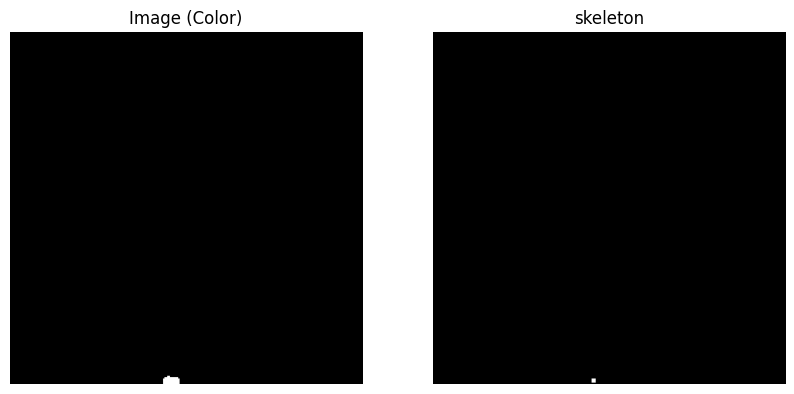

In [12]:
# Function to display a random image and its mask
def display_random_image_with_skeleton(dataset):
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and skeleton
    image, skeleton = dataset[idx]

    # If tensors, convert to PIL for visualization
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    if isinstance(skeleton, torch.Tensor):
        skeleton = T.ToPILImage()(skeleton)

    # Display the image and mask
    plt.figure(figsize=(10, 5))

    # Display image in color
    plt.subplot(1, 2, 1)
    plt.imshow(image,cmap="gray")  # Displays image in GrayScale
    plt.title("Image (Color)")
    plt.axis("off")

    # Display skeleton
    plt.subplot(1, 2, 2)
    plt.imshow(skeleton, cmap="gray")
    plt.title("skeleton")
    plt.axis("off")

    plt.show()

# Display random image with skeleton from training dataset
display_random_image_with_skeleton(train_dataset)

# **Model (UNet Architecture)**

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        self.upsample_to_input = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec1 = self.upconv1(enc4)
        dec2 = self.upconv2(dec1 + enc3)
        dec3 = self.upconv3(dec2 + enc2)

        final = self.final(dec3 + enc1)

        if final.shape[-2:] != x.shape[-2:]:
            final = self.upsample_to_input(final)

        return final

# **Loss Functions**

In [14]:
def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [15]:
def dice_loss(pred, target, smooth=1e-6, foreground_weight=0.95, background_weight=0.05):
    """
    Compute the weighted Dice Loss for 2D segmentation tasks.

    Args:
        pred (torch.Tensor): Predicted logits of shape (batch_size, 1, H, W).
        target (torch.Tensor): Ground truth binary masks of shape (batch_size, 1, H, W).
        smooth (float): Smoothing factor to avoid division by zero.
        foreground_weight (float): Weight for the foreground class.
        background_weight (float): Weight for the background class.

    Returns:
        torch.Tensor: The weighted Dice Loss.
    """
    # Apply sigmoid activation to the predictions to get probabilities
    pred = torch.sigmoid(pred)

    # Ensure target shape matches prediction shape
    if target.shape != pred.shape:
        target = torch.nn.functional.interpolate(target, size=pred.shape[2:], mode="bilinear", align_corners=False)

    # Flatten for Dice loss computation
    pred = pred.view(pred.size(0), -1)  # Shape: (batch_size, H*W)
    target = target.view(target.size(0), -1)  # Shape: (batch_size, H*W)

    # Calculate the intersection, sum of predictions, and sum of targets
    intersection = (pred * target).sum(dim=1)  # Shape: (batch_size,)
    pred_sum = pred.sum(dim=1)  # Shape: (batch_size,)
    target_sum = target.sum(dim=1)  # Shape: (batch_size,)

    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    # Apply weights for foreground and background
    target_mean = target.mean(dim=1)  # Average presence of foreground pixels
    weighted_dice = (
        foreground_weight * dice * target_mean +
        background_weight * dice * (1 - target_mean)
    )

    # Return the average Dice Loss across the batch
    return 1 - weighted_dice.mean()

In [16]:
def focal_loss(pred, target, alpha=0.25, gamma=2.0, smooth=1e-6):
    """
    Compute the focal loss for binary segmentation tasks.

    Args:
        pred (torch.Tensor): Predicted logits of shape (batch_size, 1, H, W).
        target (torch.Tensor): Ground truth binary masks of shape (batch_size, 1, H, W).
        alpha (float): Weighting factor for the class imbalance (default: 0.25).
        gamma (float): Focusing parameter to emphasize hard examples (default: 2.0).
        smooth (float): Smoothing term to prevent numerical instability.

    Returns:
        torch.Tensor: The focal loss.
    """
    # Apply sigmoid activation to predictions
    pred = torch.sigmoid(pred)

    # Ensure target shape matches prediction shape
    if target.shape != pred.shape:
        target = torch.nn.functional.interpolate(target, size=pred.shape[2:], mode="bilinear", align_corners=False)

    # Compute binary cross-entropy
    bce = -target * torch.log(pred + smooth) - (1 - target) * torch.log(1 - pred + smooth)

    # Compute the focal loss term
    pt = torch.where(target == 1, pred, 1 - pred)
    focal_term = (alpha * (1 - pt) ** gamma)

    # Combine BCE and Focal Term
    loss = focal_term * bce

    return loss.mean()

In [17]:
def combined_loss(pred, target, alpha=0.5):
    loss1 = dice_loss(pred, target, foreground_weight=0.95, background_weight=0.05)
    loss2 = focal_loss(pred, target, alpha=0.8, gamma=2.0)
    return alpha * loss1 + (1 - alpha) * loss2

# **Model Training**

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## *Save the Model & Training History*

In [19]:
# Training loop
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, skeleton in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, skeleton = images.to(device), skeleton.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        # Compute the combined loss
        loss = combined_loss(outputs, skeleton)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}")

    # Validation step
    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for images, skeleton in val_loader:
            images, skeleton = images.to(device), skeleton.to(device)
            outputs = model(images)

            val_loss += combined_loss(outputs, skeleton).item()
            iou += iou_score(outputs, skeleton).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

    # Step the scheduler
    scheduler.step(avg_val_loss)

Epoch 1/100: 100%|██████████| 43/43 [14:05<00:00, 19.67s/it]


Epoch 1: Train Loss: 0.5316422262857127
Validation Loss: 0.5305553728883917, IoU Score: 0.1377746875990521


Epoch 2/100: 100%|██████████| 43/43 [00:34<00:00,  1.26it/s]


Epoch 2: Train Loss: 0.511871243632117
Validation Loss: 0.5113612359220331, IoU Score: 0.1387344402345744


Epoch 3/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 3: Train Loss: 0.507798126963682
Validation Loss: 0.5073015202175487, IoU Score: 0.13380295851013876


Epoch 4/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 4: Train Loss: 0.505927162114964
Validation Loss: 0.5054980895736001, IoU Score: 0.1365899843248454


Epoch 5/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 5: Train Loss: 0.504812452682229
Validation Loss: 0.5045105760747736, IoU Score: 0.13847220689058304


Epoch 6/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 6: Train Loss: 0.5040157520493795
Validation Loss: 0.5037319118326361, IoU Score: 0.13796380229971625


Epoch 7/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 7: Train Loss: 0.5034833799961002
Validation Loss: 0.5033614310351285, IoU Score: 0.14391943473707547


Epoch 8/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 8: Train Loss: 0.503028832202734
Validation Loss: 0.5028983517126604, IoU Score: 0.14608994397250089


Epoch 9/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 9: Train Loss: 0.5027100596317026
Validation Loss: 0.502653035250577, IoU Score: 0.14971644905480472


Epoch 10/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 10: Train Loss: 0.5024589216986368
Validation Loss: 0.5024801763621244, IoU Score: 0.16048375110734592


Epoch 11/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 11: Train Loss: 0.5022445334944614
Validation Loss: 0.5022470625964078, IoU Score: 0.15366920557889072


Epoch 12/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 12: Train Loss: 0.502076922461044
Validation Loss: 0.5021269483999773, IoU Score: 0.15553705868395892


Epoch 13/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 13: Train Loss: 0.5019399343534957
Validation Loss: 0.5019922310655768, IoU Score: 0.1562282531098886


Epoch 14/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 14: Train Loss: 0.5018158915431
Validation Loss: 0.5018626288934187, IoU Score: 0.15624561499465595


Epoch 15/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 15: Train Loss: 0.5017034813415172
Validation Loss: 0.5017712929032065, IoU Score: 0.15779706768014215


Epoch 16/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 16: Train Loss: 0.5016006633292797
Validation Loss: 0.5016481388698925, IoU Score: 0.15978340194983917


Epoch 17/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 17: Train Loss: 0.5015029103256935
Validation Loss: 0.5015590732747858, IoU Score: 0.1594150479544293


Epoch 18/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 18: Train Loss: 0.5014071824938752
Validation Loss: 0.5014766779812899, IoU Score: 0.1682136356830597


Epoch 19/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 19: Train Loss: 0.5013125913087711
Validation Loss: 0.5014247406612743, IoU Score: 0.17130143601786008


Epoch 20/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 20: Train Loss: 0.501221708087034
Validation Loss: 0.5013627301562916, IoU Score: 0.17310704832727258


Epoch 21/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 21: Train Loss: 0.5011265818462816
Validation Loss: 0.501313946463845, IoU Score: 0.17273607240481811


Epoch 22/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 22: Train Loss: 0.5010328875031582
Validation Loss: 0.5013316219503229, IoU Score: 0.1675526723265648


Epoch 23/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 23: Train Loss: 0.5009362558985866
Validation Loss: 0.5013881434093822, IoU Score: 0.1589321636340835


Epoch 24/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 24: Train Loss: 0.5008508410564688
Validation Loss: 0.5012701912359758, IoU Score: 0.17347574030811136


Epoch 25/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 25: Train Loss: 0.5007699630981268
Validation Loss: 0.5012132579630072, IoU Score: 0.17050117660652508


Epoch 26/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 26: Train Loss: 0.5006736447644788
Validation Loss: 0.501337159763683, IoU Score: 0.16564550657163968


Epoch 27/100: 100%|██████████| 43/43 [00:33<00:00,  1.30it/s]


Epoch 27: Train Loss: 0.5005863308906555
Validation Loss: 0.5013207251375372, IoU Score: 0.17991636828942734


Epoch 28/100: 100%|██████████| 43/43 [00:34<00:00,  1.26it/s]


Epoch 28: Train Loss: 0.5005001300989196
Validation Loss: 0.5012033094059337, IoU Score: 0.22449055855924432


Epoch 29/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 29: Train Loss: 0.5004133609838264
Validation Loss: 0.5013167749751698, IoU Score: 0.22857645289464432


Epoch 30/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 30: Train Loss: 0.5003220300341762
Validation Loss: 0.5011743632229891, IoU Score: 0.22316777841611343


Epoch 31/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 31: Train Loss: 0.5002110371755999
Validation Loss: 0.5012266419150613, IoU Score: 0.22466729310425845


Epoch 32/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 32: Train Loss: 0.5000531486300535
Validation Loss: 0.5011205510659651, IoU Score: 0.21840141307223926


Epoch 33/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 33: Train Loss: 0.49993362121803814
Validation Loss: 0.5011355605992404, IoU Score: 0.22387313165447928


Epoch 34/100: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


Epoch 34: Train Loss: 0.49988563046898954
Validation Loss: 0.5011486844582991, IoU Score: 0.22672528299418362


Epoch 35/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 35: Train Loss: 0.4998499827329503
Validation Loss: 0.5011615265499462, IoU Score: 0.22808278690684924


Epoch 36/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 36: Train Loss: 0.49981773939243584
Validation Loss: 0.5011726834557273, IoU Score: 0.22879315370863135


Epoch 37/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 37: Train Loss: 0.49978769587916
Validation Loss: 0.5011841979893771, IoU Score: 0.2303334203633395


Epoch 38/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 38: Train Loss: 0.499758638614832
Validation Loss: 0.5011968883601102, IoU Score: 0.23090094869787042


Epoch 39/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 39: Train Loss: 0.4997262344803921
Validation Loss: 0.5012232986363497, IoU Score: 0.228574584830891


Epoch 40/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 40: Train Loss: 0.4997158598068149
Validation Loss: 0.5012274384498596, IoU Score: 0.2280190885066986


Epoch 41/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 41: Train Loss: 0.49971158975778623
Validation Loss: 0.5012294975194064, IoU Score: 0.22812285206534647


Epoch 42/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 42: Train Loss: 0.4997080668460491
Validation Loss: 0.5012314861471002, IoU Score: 0.228228052908724


Epoch 43/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 43: Train Loss: 0.49970471997593724
Validation Loss: 0.5012334043329413, IoU Score: 0.22843202813105148


Epoch 44/100: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


Epoch 44: Train Loss: 0.49970145280971084
Validation Loss: 0.5012354471466758, IoU Score: 0.22858603569594296


Epoch 45/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 45: Train Loss: 0.4996966497842656
Validation Loss: 0.5012372136116028, IoU Score: 0.22815761105580765


Epoch 46/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 46: Train Loss: 0.4996961715609528
Validation Loss: 0.5012377229603854, IoU Score: 0.22817787257107822


Epoch 47/100: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


Epoch 47: Train Loss: 0.49969578482383903
Validation Loss: 0.5012380101464011, IoU Score: 0.22814751890572635


Epoch 48/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 48: Train Loss: 0.4996954348198203
Validation Loss: 0.5012382539835843, IoU Score: 0.22825767370787534


Epoch 49/100: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


Epoch 49: Train Loss: 0.49969509105349696
Validation Loss: 0.5012384707277472, IoU Score: 0.22826533967798407


Epoch 50/100: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


Epoch 50: Train Loss: 0.49969475005948266
Validation Loss: 0.501238692890514, IoU Score: 0.22822906483303418


Epoch 51/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 51: Train Loss: 0.49969427114309267
Validation Loss: 0.5012387741695751, IoU Score: 0.22822202335704456


Epoch 52/100: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


Epoch 52: Train Loss: 0.49969424549923386
Validation Loss: 0.5012388120998036, IoU Score: 0.22822741893204776


Epoch 53/100: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


Epoch 53: Train Loss: 0.49969421638998873
Validation Loss: 0.5012388229370117, IoU Score: 0.22823922471566635


Epoch 54/100: 100%|██████████| 43/43 [00:34<00:00,  1.26it/s]


Epoch 54: Train Loss: 0.4996941852015118
Validation Loss: 0.5012388554486361, IoU Score: 0.22824344445358624


Epoch 55/100: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


Epoch 55: Train Loss: 0.4996941540130349
Validation Loss: 0.5012388825416565, IoU Score: 0.2282516983422366


Epoch 56/100:   2%|▏         | 1/43 [00:01<01:04,  1.54s/it]


KeyboardInterrupt: 

In [20]:
# Define the model save path
model_save_dir = "/content/drive/MyDrive/Skeleton_Trained_Model_2D"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
def save_model(model, model_save_dir):
    model_path = os.path.join(model_save_dir, "model_v3.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

# Call the function to save the model
save_model(model, model_save_dir)

Model saved at /content/drive/MyDrive/Skeleton_Trained_Model_2D/model_v3.pth


In [21]:
import pickle

# Save the training history (as a pickle file)
history_path = os.path.join(model_save_dir, "history_v3.pkl")

with open(history_path, 'wb') as history_file:
    pickle.dump(history, history_file)

print(f"History saved at {history_path}")

History saved at /content/drive/MyDrive/Skeleton_Trained_Model_2D/history_v3.pkl


## *Load the Model & Training History*

In [ ]:
# Define the model instance
model = UNet(in_channels=1, out_channels=1)  # Example for input RGB images and binary segmentation output
model.load_state_dict(torch.load(model_save_dir+"/model.pth"))

# If using GPU, move the model to the correct device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Load the history
with open(os.path.join(model_save_dir, "history.pkl"), 'rb') as history_file:
    history = pickle.load(history_file)

print("Model and history loaded successfully!")

## *Visualize the Training History*

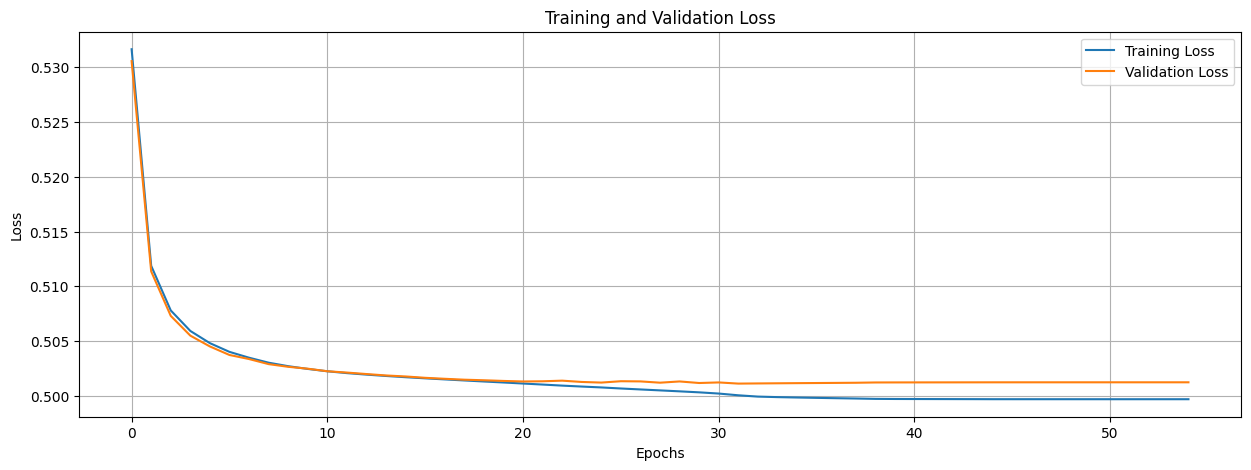

In [22]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

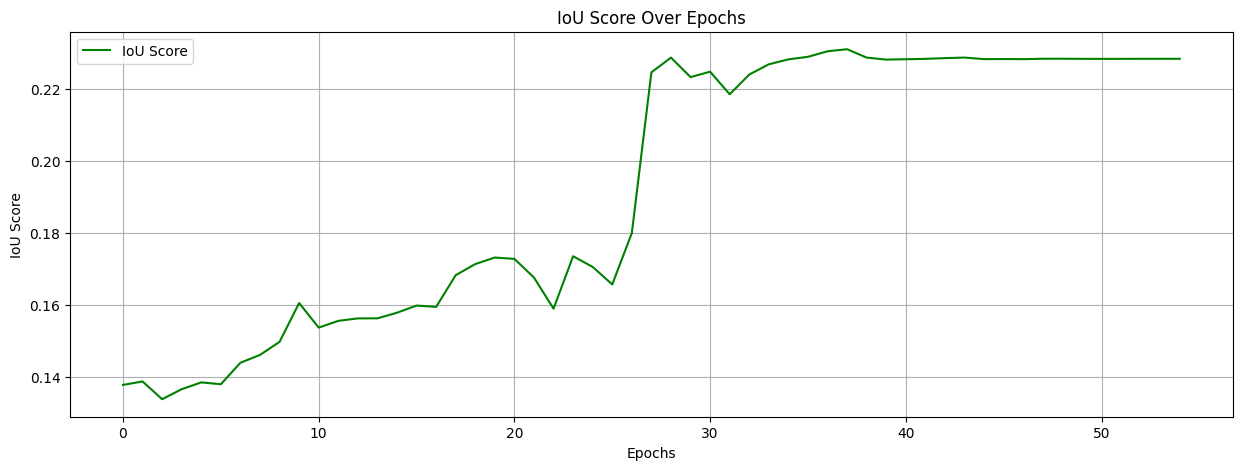

In [23]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# **Evaluate the Model**

## *Validation and Testing*

In [24]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [25]:
def dice_coefficient(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

# Evaluate model on test dataset
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

    with torch.no_grad():
        for images, skeleton in dataloader:
            images, skeleton = images.to(device), skeleton.to(device)
            outputs = model(images)
            preds = (outputs.sigmoid() > threshold).float()

            for pred, skeleton in zip(preds, skeleton):
                dice_scores.append(dice_coefficient(pred.cpu().numpy(), skeleton.cpu().numpy()))
                iou_scores.append(iou(pred.cpu().numpy(), skeleton.cpu().numpy()))
                precisions.append(precision_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                recalls.append(recall_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                f1s.append(f1_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))

    print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"IoU: {np.mean(iou_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")

In [26]:
evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: 

Dice Coefficient: 0.1901
IoU: 0.1173
Precision: 0.2547
Recall: 0.1645
F1 Score: 0.1901


## *Error Analysis*

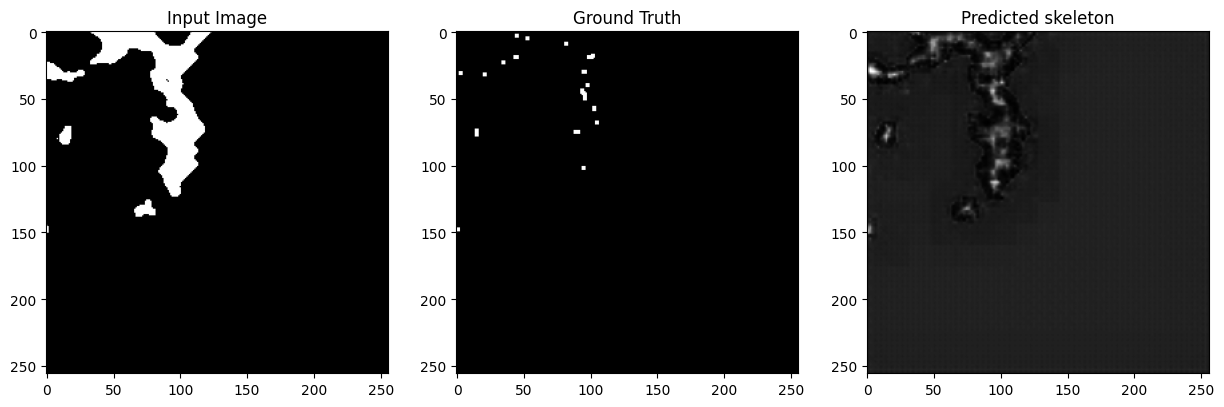

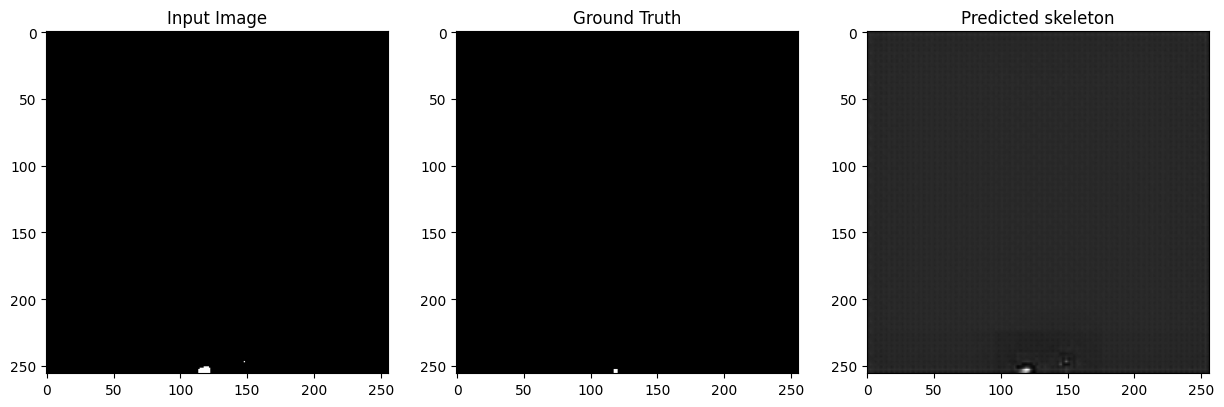

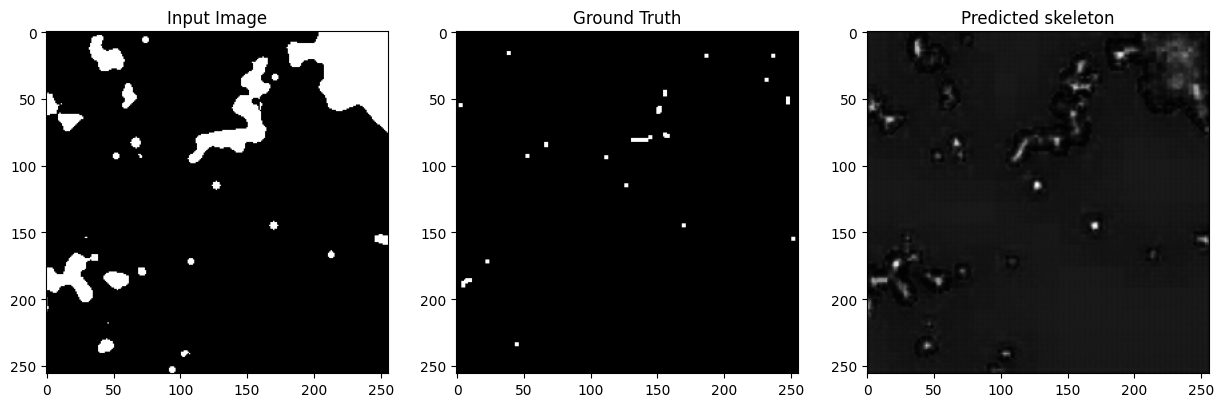

In [28]:
# Set the model to evaluation mode
model.eval()

i = 0

with torch.no_grad():
    for images, skeleton in test_loader:
        # Move images and masks to the device
        images, skeleton = images.to(device), skeleton.to(device)

        # Get the model outputs
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid and move to CPU
        outputs = (outputs * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

        images = images.cpu().numpy()
        skeleton = skeleton.cpu().numpy()

        # Visualize the input image, ground truth, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))

        # Input image (grayscale)
        axes[0].imshow(images[0, 0], cmap='gray')
        axes[0].set_title("Input Image")

        # Ground truth mask (binary, scaled to [0, 255] for visualization)
        axes[1].imshow(skeleton[0, 0], cmap='gray')
        axes[1].set_title("Ground Truth")

        # Predicted mask (scaled to [0, 255])
        axes[2].imshow(outputs[0, 0], cmap='gray')
        axes[2].set_title("Predicted skeleton")

        # Display the visualization
        plt.show()

        if i == 2:
          break
        i += 1

# **Interpret Results**